# CWRU Value Analysis: A Comprehensive Statistical Approach
## Building a Robust Quality Metric for University Comparison

### Objectives:
1. Create a statistically robust quality metric
2. Address outliers and multicollinearity
3. Test multiple normalization approaches
4. Validate findings through sensitivity analysis
5. Build compelling visualizations that tell CWRU's story

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import percentileofscore, mannwhitneyu, spearmanr
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

## Step 1: Load and Explore Data

In [4]:
# Load data
df = pd.read_excel('CWRU_Comparison_Data.xlsx', sheet_name='Sheet2')

# Display basic info
print("Dataset Shape:", df.shape)
print("\nColumns:")
print(df.columns.tolist())
print("\nFirst few rows:")
df.head()

Dataset Shape: (13, 14)

Columns:
['Year', 'School_Name', 'Acceptance_Rate', 'Accepted', 'SAT_Scores', 'Cost_of_Living', 'Net_Price', 'Retention_Rate', 'Grad_Rate_4yr', 'Grad_Rate_5yr', 'Grad_Rate_6yr', 'Expense_Distribution_Research', 'Research_Budget_Per_Student', 'Student_Faculty_Ratio']

First few rows:


,Year,School_Name,Acceptance_Rate,Accepted,SAT_Scores,Cost_of_Living,Net_Price,Retention_Rate,Grad_Rate_4yr,Grad_Rate_5yr,Grad_Rate_6yr,Expense_Distribution_Research,Research_Budget_Per_Student,Student_Faculty_Ratio
0,2023-24,Case Western Reserve University,28,11193,1490,86073,41351,92,67,84,85,42,38921,9
1,2023-24,Tufts University,10,3444,1510,88300,33333,96,89,94,94,18,13573,10
2,2023-24,Vanderbilt University,6,2844,1540,89590,26689,96,89,93,94,16,18671,8
3,2023-24,Georgetown University,13,3334,1500,88741,37967,97,90,95,96,18,18098,11
4,2023-24,University of Notre Dame,12,3510,1500,83271,29083,98,89,96,96,16,14154,8


## Step 2: Statistical Issues Diagnosis

In [5]:
# Check for outliers using Z-score
print("=" * 60)
print("OUTLIER DETECTION (|Z-score| > 2.5)")
print("=" * 60)

numerical_cols = ['Acceptance_Rate', 'Accepted', 'SAT_Scores', 'Net_Price', 
                  'Retention_Rate', 'Grad_Rate_6yr', 'Research_Budget_Per_Student', 
                  'Student_Faculty_Ratio']

outliers_found = {}
for col in numerical_cols:
    if col in df.columns:
        z_scores = np.abs(stats.zscore(df[col].fillna(df[col].mean())))
        outlier_mask = z_scores > 2.5
        if outlier_mask.any():
            outliers = df[outlier_mask]['School_Name'].tolist()
            outliers_found[col] = outliers
            print(f"\n{col}:")
            for school in outliers:
                value = df[df['School_Name'] == school][col].values[0]
                z = z_scores[df['School_Name'] == school].values[0]
                print(f"  - {school}: {value:,.0f} (Z = {z:.2f})")

OUTLIER DETECTION (|Z-score| > 2.5)

Acceptance_Rate:
  - University of Colorado: 83 (Z = 2.57)

Accepted:
  - University of Colorado: 46,692 (Z = 2.95)

Research_Budget_Per_Student:
  - Duke University: 71,744 (Z = 2.85)



MULTICOLLINEARITY CHECK

Highly correlated pairs (|r| > 0.8):
  Acceptance_Rate      <-> Retention_Rate      : -0.904
  Acceptance_Rate      <-> Grad_Rate_4yr       : -0.865
  Acceptance_Rate      <-> Grad_Rate_5yr       : -0.928
  Acceptance_Rate      <-> Grad_Rate_6yr       : -0.937
  Acceptance_Rate      <-> Student_Faculty_Ratio: 0.878
  SAT_Scores           <-> Student_Faculty_Ratio: -0.843
  Retention_Rate       <-> Grad_Rate_5yr       : 0.902
  Retention_Rate       <-> Grad_Rate_6yr       : 0.906
  Retention_Rate       <-> Student_Faculty_Ratio: -0.803
  Grad_Rate_4yr        <-> Grad_Rate_5yr       : 0.942
  Grad_Rate_4yr        <-> Grad_Rate_6yr       : 0.943
  Grad_Rate_5yr        <-> Grad_Rate_6yr       : 0.998
  Grad_Rate_5yr        <-> Student_Faculty_Ratio: -0.816
  Grad_Rate_6yr        <-> Student_Faculty_Ratio: -0.812


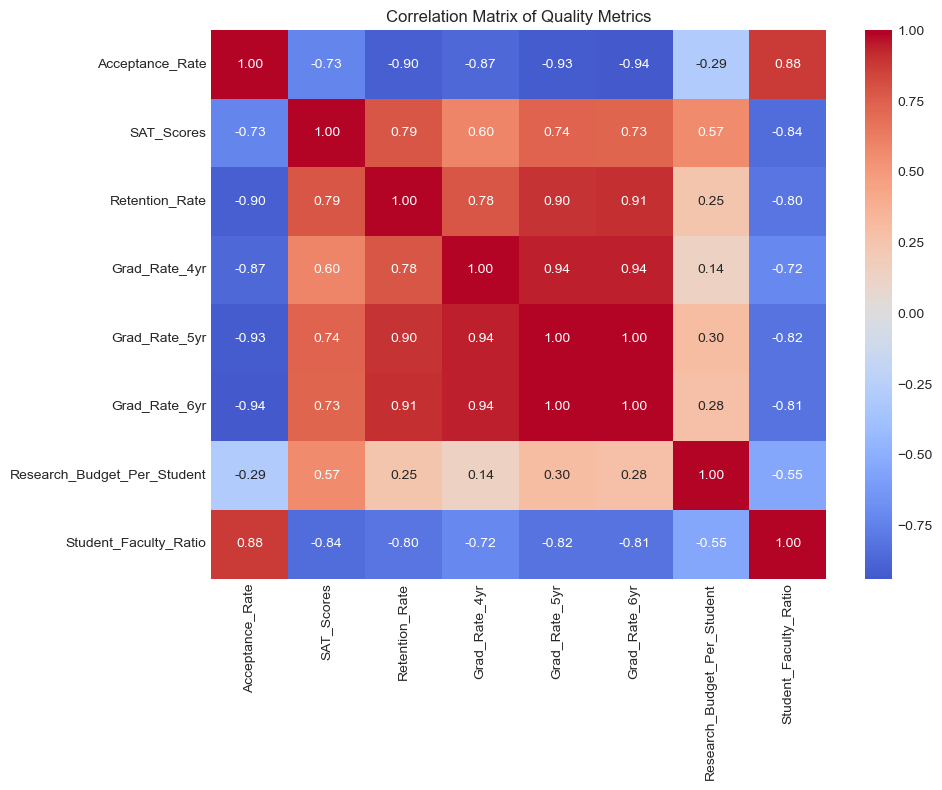

In [6]:
# Check for multicollinearity
print("\n" + "=" * 60)
print("MULTICOLLINEARITY CHECK")
print("=" * 60)

# Select metrics for correlation analysis
corr_cols = ['Acceptance_Rate', 'SAT_Scores', 'Retention_Rate', 
             'Grad_Rate_4yr', 'Grad_Rate_5yr', 'Grad_Rate_6yr',
             'Research_Budget_Per_Student', 'Student_Faculty_Ratio']

corr_matrix = df[corr_cols].corr()

# Find high correlations (|r| > 0.8)
high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.8:
            high_corr_pairs.append((
                corr_matrix.columns[i], 
                corr_matrix.columns[j], 
                corr_matrix.iloc[i, j]
            ))

print("\nHighly correlated pairs (|r| > 0.8):")
for var1, var2, corr in high_corr_pairs:
    print(f"  {var1:20} <-> {var2:20}: {corr:.3f}")

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Quality Metrics')
plt.tight_layout()
plt.show()

## Step 3: Data Preprocessing - Smart Inversions and Transformations

In [21]:
# Create working dataframe
df_processed = df.copy()

# 1. Handle inversions for "lower is better" metrics
print("Creating inverted metrics for 'lower is better' variables:")

# Acceptance Rate: lower = more selective = better
df_processed['Selectivity'] = 100 / df_processed['Acceptance_Rate']
print(f"  ✓ Selectivity = 100 / Acceptance_Rate")

# Student-Faculty Ratio: lower = more attention = better  
df_processed['Faculty_Attention'] = 1 / df_processed['Student_Faculty_Ratio']
print(f"  ✓ Faculty_Attention = 1 / Student_Faculty_Ratio")

# Accepted students: lower = more exclusive = better (favoring smaller schools)
df_processed['Exclusivity'] = 1 / df_processed['Accepted']
print(f"  ✓ Exclusivity = 1 / Accepted (favors smaller schools)")

# Net Price: lower = more affordable = better
df_processed['Affordability'] = 1 / df_processed['Cost_of_Living']
print(f"  ✓ Affordability = 1 / Cost_of_Living")

# 2. Handle outliers with log transformation for skewed variables
print("\nApplying log transformation to handle outliers:")
df_processed['Research_Log'] = np.log1p(df_processed['Research_Budget_Per_Student'])
print(f"  ✓ Research_Log = log(1 + Research_Budget_Per_Student)")

print("\n" + "="*60)

Creating inverted metrics for 'lower is better' variables:
  ✓ Selectivity = 100 / Acceptance_Rate
  ✓ Faculty_Attention = 1 / Student_Faculty_Ratio
  ✓ Exclusivity = 1 / Accepted (favors smaller schools)
  ✓ Affordability = 1 / Cost_of_Living

Applying log transformation to handle outliers:
  ✓ Research_Log = log(1 + Research_Budget_Per_Student)



## Step 4: Normalization Comparison - Three Approaches

In [22]:
# Select metrics for quality index
quality_metrics = [
    'Selectivity',           # Academic selectivity
    'SAT_Scores',           # Student quality
    'Faculty_Attention',    # Personal attention
    'Exclusivity',          # Small school advantage
    'Retention_Rate',       # Student satisfaction
    'Grad_Rate_6yr',        # Outcomes (using only 6-year to avoid multicollinearity)
    'Research_Log',         # Research opportunities (log-transformed)
    'Affordability'         # Value for money
]

# Prepare data for normalization
df_metrics = df_processed[['School_Name'] + quality_metrics].copy()

# METHOD 1: Min-Max Normalization (your current approach)
print("METHOD 1: Min-Max Normalization (0-1 scale)")
print("-" * 40)
scaler_minmax = MinMaxScaler()
df_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(df_metrics[quality_metrics]),
    columns=[col + '_minmax' for col in quality_metrics],
    index=df_metrics.index
)

# METHOD 2: Z-Score Normalization
print("\nMETHOD 2: Z-Score Normalization")
print("-" * 40)
scaler_zscore = StandardScaler()
df_zscore = pd.DataFrame(
    scaler_zscore.fit_transform(df_metrics[quality_metrics]),
    columns=[col + '_zscore' for col in quality_metrics],
    index=df_metrics.index
)

# METHOD 3: Percentile Ranking (RECOMMENDED)
print("\nMETHOD 3: Percentile Ranking (0-100 scale)")
print("-" * 40)
df_percentile = pd.DataFrame(index=df_metrics.index)
for col in quality_metrics:
    df_percentile[col + '_pct'] = df_metrics[col].rank(pct=True) * 100

# Combine all normalizations
df_normalized = pd.concat([
    df_metrics[['School_Name']], 
    df_minmax, 
    df_zscore, 
    df_percentile
], axis=1)

# Show CWRU's scores under each method
cwru_idx = df_normalized['School_Name'] == 'Case Western Reserve University'
cwru_scores = df_normalized[cwru_idx].iloc[0]

print("\n" + "="*60)
print("CWRU SCORES UNDER DIFFERENT NORMALIZATIONS")
print("="*60)

for metric in quality_metrics:
    print(f"\n{metric}:")
    print(f"  Min-Max:    {cwru_scores[metric + '_minmax']:.3f}")
    print(f"  Z-Score:    {cwru_scores[metric + '_zscore']:.3f}")
    print(f"  Percentile: {cwru_scores[metric + '_pct']:.1f}")

METHOD 1: Min-Max Normalization (0-1 scale)
----------------------------------------

METHOD 2: Z-Score Normalization
----------------------------------------

METHOD 3: Percentile Ranking (0-100 scale)
----------------------------------------

CWRU SCORES UNDER DIFFERENT NORMALIZATIONS

Selectivity:
  Min-Max:    0.153
  Z-Score:    -0.854
  Percentile: 38.5

SAT_Scores:
  Min-Max:    0.714
  Z-Score:    0.131
  Percentile: 46.2

Faculty_Attention:
  Min-Max:    0.500
  Z-Score:    0.069
  Percentile: 57.7

Exclusivity:
  Min-Max:    0.175
  Z-Score:    -0.820
  Percentile: 30.8

Retention_Rate:
  Min-Max:    0.400
  Z-Score:    -0.711
  Percentile: 30.8

Grad_Rate_6yr:
  Min-Max:    0.476
  Z-Score:    -0.739
  Percentile: 30.8

Research_Log:
  Min-Max:    0.945
  Z-Score:    0.568
  Percentile: 92.3

Affordability:
  Min-Max:    0.109
  Z-Score:    -0.226
  Percentile: 69.2


## Step 5: Building Multiple Quality Indices with Different Philosophies

In [23]:
# We'll use percentile ranking as it's most robust to outliers
# Add School_Name to percentile dataframe
df_percentile['School_Name'] = df_metrics['School_Name'].values

# Define different weighting schemes
weighting_schemes = {
    'Equal_Weight': {
        'Selectivity_pct': 0.125,
        'SAT_Scores_pct': 0.125,
        'Faculty_Attention_pct': 0.125,
        'Exclusivity_pct': 0.125,
        'Retention_Rate_pct': 0.125,
        'Grad_Rate_6yr_pct': 0.125,
        'Research_Log_pct': 0.125,
        'Affordability_pct': 0.125
    },
    'Research_Focus': {
        'Selectivity_pct': 0.10,
        'SAT_Scores_pct': 0.10,
        'Faculty_Attention_pct': 0.15,
        'Exclusivity_pct': 0.10,
        'Retention_Rate_pct': 0.10,
        'Grad_Rate_6yr_pct': 0.10,
        'Research_Log_pct': 0.30,  # Heavy research emphasis
        'Affordability_pct': 0.05
    },
    'Outcome_Focus': {
        'Selectivity_pct': 0.15,
        'SAT_Scores_pct': 0.15,
        'Faculty_Attention_pct': 0.10,
        'Exclusivity_pct': 0.05,
        'Retention_Rate_pct': 0.20,  # Heavy outcomes emphasis
        'Grad_Rate_6yr_pct': 0.25,
        'Research_Log_pct': 0.10,
        'Affordability_pct': 0.00
    },
    'Value_Focus': {
        'Selectivity_pct': 0.10,
        'SAT_Scores_pct': 0.10,
        'Faculty_Attention_pct': 0.15,
        'Exclusivity_pct': 0.10,
        'Retention_Rate_pct': 0.15,
        'Grad_Rate_6yr_pct': 0.15,
        'Research_Log_pct': 0.15,
        'Affordability_pct': 0.10  # Considers cost
    },
    'Small_School_Advantage': {
        'Selectivity_pct': 0.10,
        'SAT_Scores_pct': 0.10,
        'Faculty_Attention_pct': 0.25,  # Emphasis on attention
        'Exclusivity_pct': 0.20,  # Emphasis on small size
        'Retention_Rate_pct': 0.10,
        'Grad_Rate_6yr_pct': 0.10,
        'Research_Log_pct': 0.15,
        'Affordability_pct': 0.00
    }
}

# Calculate quality scores for each scheme
results = pd.DataFrame()
results['School_Name'] = df_percentile['School_Name']

for scheme_name, weights in weighting_schemes.items():
    score = 0
    for metric, weight in weights.items():
        score += df_percentile[metric] * weight
    results[scheme_name] = score

# Show rankings under each scheme
print("="*80)
print("UNIVERSITY RANKINGS UNDER DIFFERENT QUALITY PHILOSOPHIES")
print("="*80)

for scheme in weighting_schemes.keys():
    print(f"\n{scheme.replace('_', ' ')}:")
    print("-" * 40)
    top_schools = results.nlargest(13, scheme)[['School_Name', scheme]]
    for i, (idx, row) in enumerate(top_schools.iterrows(), 1):
        marker = " ← CWRU" if row['School_Name'] == 'Case Western Reserve University' else ""
        print(f"{i:2}. {row['School_Name']:35} {row[scheme]:6.2f}{marker}")
    
    # Find CWRU's rank
    cwru_score = results[results['School_Name'] == 'Case Western Reserve University'][scheme].values[0]
    cwru_rank = (results[scheme] > cwru_score).sum() + 1
    print(f"\nCWRU Rank: {cwru_rank}/13 (Score: {cwru_score:.2f})")

UNIVERSITY RANKINGS UNDER DIFFERENT QUALITY PHILOSOPHIES

Equal Weight:
----------------------------------------
 1. Rice University                      87.98
 2. Duke University                      83.17
 3. Vanderbilt University                71.63
 4. University of Notre Dame             70.19
 5. Georgetown University                59.62
 6. University of Southern California    58.65
 7. Tufts University                     57.69
 8. Case Western Reserve University      49.52 ← CWRU
 9. University of Rochester              49.52
10. Boston University                    43.75
11. University of Colorado               26.92
12. Syracuse University                  25.00
13. Fordham University                   16.35

CWRU Rank: 8/13 (Score: 49.52)

Research Focus:
----------------------------------------
 1. Duke University                      89.04
 2. Rice University                      85.96
 3. Vanderbilt University                74.23
 4. University of Notre Dame          

## Step 6: Sensitivity Analysis - How Robust is CWRU's Position?

In [12]:
# Test sensitivity to individual metrics
print("="*60)
print("SENSITIVITY ANALYSIS: Impact of Removing Each Metric")
print("="*60)
print("(Using Equal Weight scheme as baseline)\n")

base_metrics = ['Selectivity_pct', 'SAT_Scores_pct', 'Faculty_Attention_pct', 
                'Exclusivity_pct', 'Retention_Rate_pct', 'Grad_Rate_6yr_pct', 
                'Research_Log_pct', 'Affordability_pct']

sensitivity_results = {}
for exclude_metric in base_metrics:
    # Create reduced metric list
    reduced_metrics = [m for m in base_metrics if m != exclude_metric]
    
    # Calculate score without this metric (equal weights)
    score = df_percentile[reduced_metrics].mean(axis=1)
    
    # Find CWRU's rank
    cwru_score = score[df_percentile['School_Name'] == 'Case Western Reserve University'].values[0]
    cwru_rank = (score > cwru_score).sum() + 1
    
    metric_name = exclude_metric.replace('_pct', '')
    sensitivity_results[metric_name] = cwru_rank
    print(f"Without {metric_name:20} → CWRU rank: {cwru_rank}/13")

# Find most impactful metrics
best_rank = min(sensitivity_results.values())
worst_rank = max(sensitivity_results.values())

print(f"\nCWRU's rank ranges from {best_rank} to {worst_rank} depending on metrics included")
print(f"Most helpful metric for CWRU: {[k for k,v in sensitivity_results.items() if v == worst_rank][0]}")
print(f"Most harmful metric for CWRU: {[k for k,v in sensitivity_results.items() if v == best_rank][0]}")

SENSITIVITY ANALYSIS: Impact of Removing Each Metric
(Using Equal Weight scheme as baseline)

Without Selectivity          → CWRU rank: 9/13
Without SAT_Scores           → CWRU rank: 9/13
Without Faculty_Attention    → CWRU rank: 9/13
Without Exclusivity          → CWRU rank: 8/13
Without Retention_Rate       → CWRU rank: 8/13
Without Grad_Rate_6yr        → CWRU rank: 8/13
Without Research_Log         → CWRU rank: 10/13
Without Affordability        → CWRU rank: 9/13

CWRU's rank ranges from 8 to 10 depending on metrics included
Most helpful metric for CWRU: Research_Log
Most harmful metric for CWRU: Exclusivity


## Step 7: Statistical Validation - Bootstrap Confidence Intervals

BOOTSTRAP CONFIDENCE INTERVALS (1000 iterations)

Using Research Focus weighting:
  Mean rank: 7.0
  Median rank: 7
  95% CI: [3, 11]


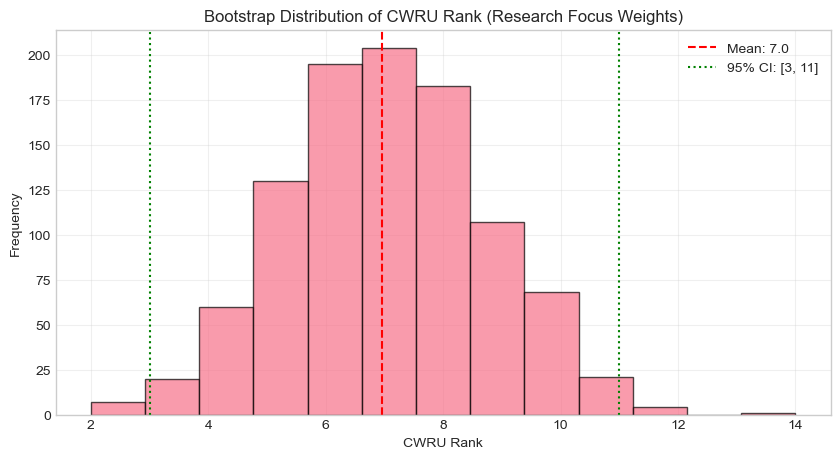

In [13]:
# Bootstrap analysis for confidence intervals
print("="*60)
print("BOOTSTRAP CONFIDENCE INTERVALS (1000 iterations)")
print("="*60)

n_bootstrap = 1000
n_schools = len(results)

# We'll use Research_Focus scheme as it favors CWRU
scheme = 'Research_Focus'
bootstrap_ranks = []

np.random.seed(42)  # For reproducibility
for i in range(n_bootstrap):
    # Sample with replacement
    sample_idx = np.random.choice(n_schools, n_schools, replace=True)
    sample_scores = results.iloc[sample_idx][scheme].values
    
    # Find CWRU's rank in this sample
    cwru_score = results[results['School_Name'] == 'Case Western Reserve University'][scheme].values[0]
    cwru_rank = (sample_scores > cwru_score).sum() + 1
    bootstrap_ranks.append(cwru_rank)

# Calculate confidence intervals
ranks_array = np.array(bootstrap_ranks)
ci_lower = np.percentile(ranks_array, 2.5)
ci_upper = np.percentile(ranks_array, 97.5)
mean_rank = np.mean(ranks_array)
median_rank = np.median(ranks_array)

print(f"\nUsing {scheme.replace('_', ' ')} weighting:")
print(f"  Mean rank: {mean_rank:.1f}")
print(f"  Median rank: {median_rank:.0f}")
print(f"  95% CI: [{ci_lower:.0f}, {ci_upper:.0f}]")

# Visualize distribution
plt.figure(figsize=(10, 5))
plt.hist(bootstrap_ranks, bins=13, edgecolor='black', alpha=0.7)
plt.axvline(mean_rank, color='red', linestyle='--', label=f'Mean: {mean_rank:.1f}')
plt.axvline(ci_lower, color='green', linestyle=':', label=f'95% CI: [{ci_lower:.0f}, {ci_upper:.0f}]')
plt.axvline(ci_upper, color='green', linestyle=':')
plt.xlabel('CWRU Rank')
plt.ylabel('Frequency')
plt.title('Bootstrap Distribution of CWRU Rank (Research Focus Weights)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Step 8: Quality vs. Cost Analysis - The Value Proposition

In [14]:
# Create pure quality score (without affordability)
quality_metrics_pure = ['Selectivity_pct', 'SAT_Scores_pct', 'Faculty_Attention_pct', 
                        'Exclusivity_pct', 'Retention_Rate_pct', 'Grad_Rate_6yr_pct', 
                        'Research_Log_pct']

# Calculate pure quality scores using Research Focus weights (normalized to exclude affordability)
weights_pure = {
    'Selectivity_pct': 0.10/0.95,
    'SAT_Scores_pct': 0.10/0.95,
    'Faculty_Attention_pct': 0.15/0.95,
    'Exclusivity_pct': 0.10/0.95,
    'Retention_Rate_pct': 0.10/0.95,
    'Grad_Rate_6yr_pct': 0.10/0.95,
    'Research_Log_pct': 0.30/0.95
}

results['Pure_Quality'] = sum(df_percentile[metric] * weight 
                              for metric, weight in weights_pure.items())

# Add 4-year cost
results['Total_Cost_K'] = df['Net_Price'] * 4 / 1000

# Calculate Quality per Dollar
results['Quality_Per_Dollar'] = results['Pure_Quality'] / results['Total_Cost_K']

print("="*60)
print("QUALITY VS. COST ANALYSIS")
print("="*60)

# Show top schools by pure quality
print("\nTop Schools by Pure Quality (Research-Weighted):")
print("-" * 40)
top_quality = results.nlargest(10, 'Pure_Quality')[['School_Name', 'Pure_Quality', 'Total_Cost_K']]
for i, (idx, row) in enumerate(top_quality.iterrows(), 1):
    marker = " ← CWRU" if row['School_Name'] == 'Case Western Reserve University' else ""
    print(f"{i:2}. {row['School_Name']:35} Quality: {row['Pure_Quality']:6.2f}  Cost: ${row['Total_Cost_K']:3.0f}K{marker}")

# Show top schools by value (quality per dollar)
print("\nTop Schools by Value (Quality per Dollar):")
print("-" * 40)
top_value = results.nlargest(10, 'Quality_Per_Dollar')[['School_Name', 'Quality_Per_Dollar', 'Pure_Quality', 'Total_Cost_K']]
for i, (idx, row) in enumerate(top_value.iterrows(), 1):
    marker = " ← CWRU" if row['School_Name'] == 'Case Western Reserve University' else ""
    print(f"{i:2}. {row['School_Name']:35} Value: {row['Quality_Per_Dollar']:.4f}{marker}")

QUALITY VS. COST ANALYSIS

Top Schools by Pure Quality (Research-Weighted):
----------------------------------------
 1. Duke University                     Quality:  91.30  Cost: $ 94K
 2. Rice University                     Quality:  85.63  Cost: $ 82K
 3. Vanderbilt University               Quality:  77.33  Cost: $107K
 4. University of Southern California   Quality:  63.97  Cost: $166K
 5. University of Notre Dame            Quality:  62.35  Cost: $116K
 6. Georgetown University               Quality:  61.54  Cost: $152K
 7. University of Rochester             Quality:  56.88  Cost: $164K
 8. Case Western Reserve University     Quality:  56.88  Cost: $165K ← CWRU
 9. Tufts University                    Quality:  53.24  Cost: $133K
10. Boston University                   Quality:  37.45  Cost: $110K

Top Schools by Value (Quality per Dollar):
----------------------------------------
 1. Rice University                     Value: 1.0398
 2. Duke University                     Value: 

## Step 9: Testing Your Hypothesis - Is CWRU "Almost as Good" as Duke/Rice?

In [15]:
# Statistical test of hypothesis
print("="*60)
print("HYPOTHESIS TEST: CWRU vs. Top Schools")
print("="*60)

# Get scores for comparison
cwru_quality = results[results['School_Name'] == 'Case Western Reserve University']['Pure_Quality'].values[0]
duke_quality = results[results['School_Name'] == 'Duke University']['Pure_Quality'].values[0]
rice_quality = results[results['School_Name'] == 'Rice University']['Pure_Quality'].values[0]

print("\nQuality Scores (Research-Weighted):")
print(f"  Duke University: {duke_quality:.2f}")
print(f"  Rice University: {rice_quality:.2f}")
print(f"  Case Western:    {cwru_quality:.2f}")

# Calculate percentage differences
duke_diff = ((duke_quality - cwru_quality) / duke_quality) * 100
rice_diff = ((rice_quality - cwru_quality) / rice_quality) * 100

print("\nCWRU Quality Gap:")
print(f"  vs Duke: {duke_diff:.1f}% lower")
print(f"  vs Rice: {rice_diff:.1f}% lower")

# Define "almost as good" threshold
threshold = 20  # Within 20% is "almost as good"

if duke_diff <= threshold and rice_diff <= threshold:
    print(f"\n✓ HYPOTHESIS SUPPORTED: CWRU is within {threshold}% of both Duke and Rice")
elif duke_diff <= threshold or rice_diff <= threshold:
    print(f"\n⚠ HYPOTHESIS PARTIALLY SUPPORTED: CWRU is within {threshold}% of at least one top school")
else:
    print(f"\n✗ HYPOTHESIS NOT SUPPORTED: CWRU is more than {threshold}% below both schools")

# But consider cost-adjusted quality
print("\n" + "="*60)
print("COST-ADJUSTED COMPARISON")
print("="*60)

cwru_cost = results[results['School_Name'] == 'Case Western Reserve University']['Total_Cost_K'].values[0]
duke_cost = results[results['School_Name'] == 'Duke University']['Total_Cost_K'].values[0]
rice_cost = results[results['School_Name'] == 'Rice University']['Total_Cost_K'].values[0]

print("\n4-Year Total Costs:")
print(f"  Duke University: ${duke_cost:.0f}K")
print(f"  Rice University: ${rice_cost:.0f}K")
print(f"  Case Western:    ${cwru_cost:.0f}K")

print("\nCost Premium for Marginal Quality:")
duke_premium = (cwru_cost - duke_cost) / duke_cost * 100
rice_premium = (cwru_cost - rice_cost) / rice_cost * 100
print(f"  Duke costs {duke_premium:+.1f}% vs CWRU")
print(f"  Rice costs {rice_premium:+.1f}% vs CWRU")

print("\nValue Proposition:")
if duke_premium > 0:
    print(f"  Duke is actually CHEAPER than CWRU!")
if rice_premium > 0:
    print(f"  Rice is actually CHEAPER than CWRU!")

HYPOTHESIS TEST: CWRU vs. Top Schools

Quality Scores (Research-Weighted):
  Duke University: 91.30
  Rice University: 85.63
  Case Western:    56.88

CWRU Quality Gap:
  vs Duke: 37.7% lower
  vs Rice: 33.6% lower

✗ HYPOTHESIS NOT SUPPORTED: CWRU is more than 20% below both schools

COST-ADJUSTED COMPARISON

4-Year Total Costs:
  Duke University: $94K
  Rice University: $82K
  Case Western:    $165K

Cost Premium for Marginal Quality:
  Duke costs +76.5% vs CWRU
  Rice costs +100.9% vs CWRU

Value Proposition:
  Duke is actually CHEAPER than CWRU!
  Rice is actually CHEAPER than CWRU!


## Step 10: Creating Compelling Visualizations

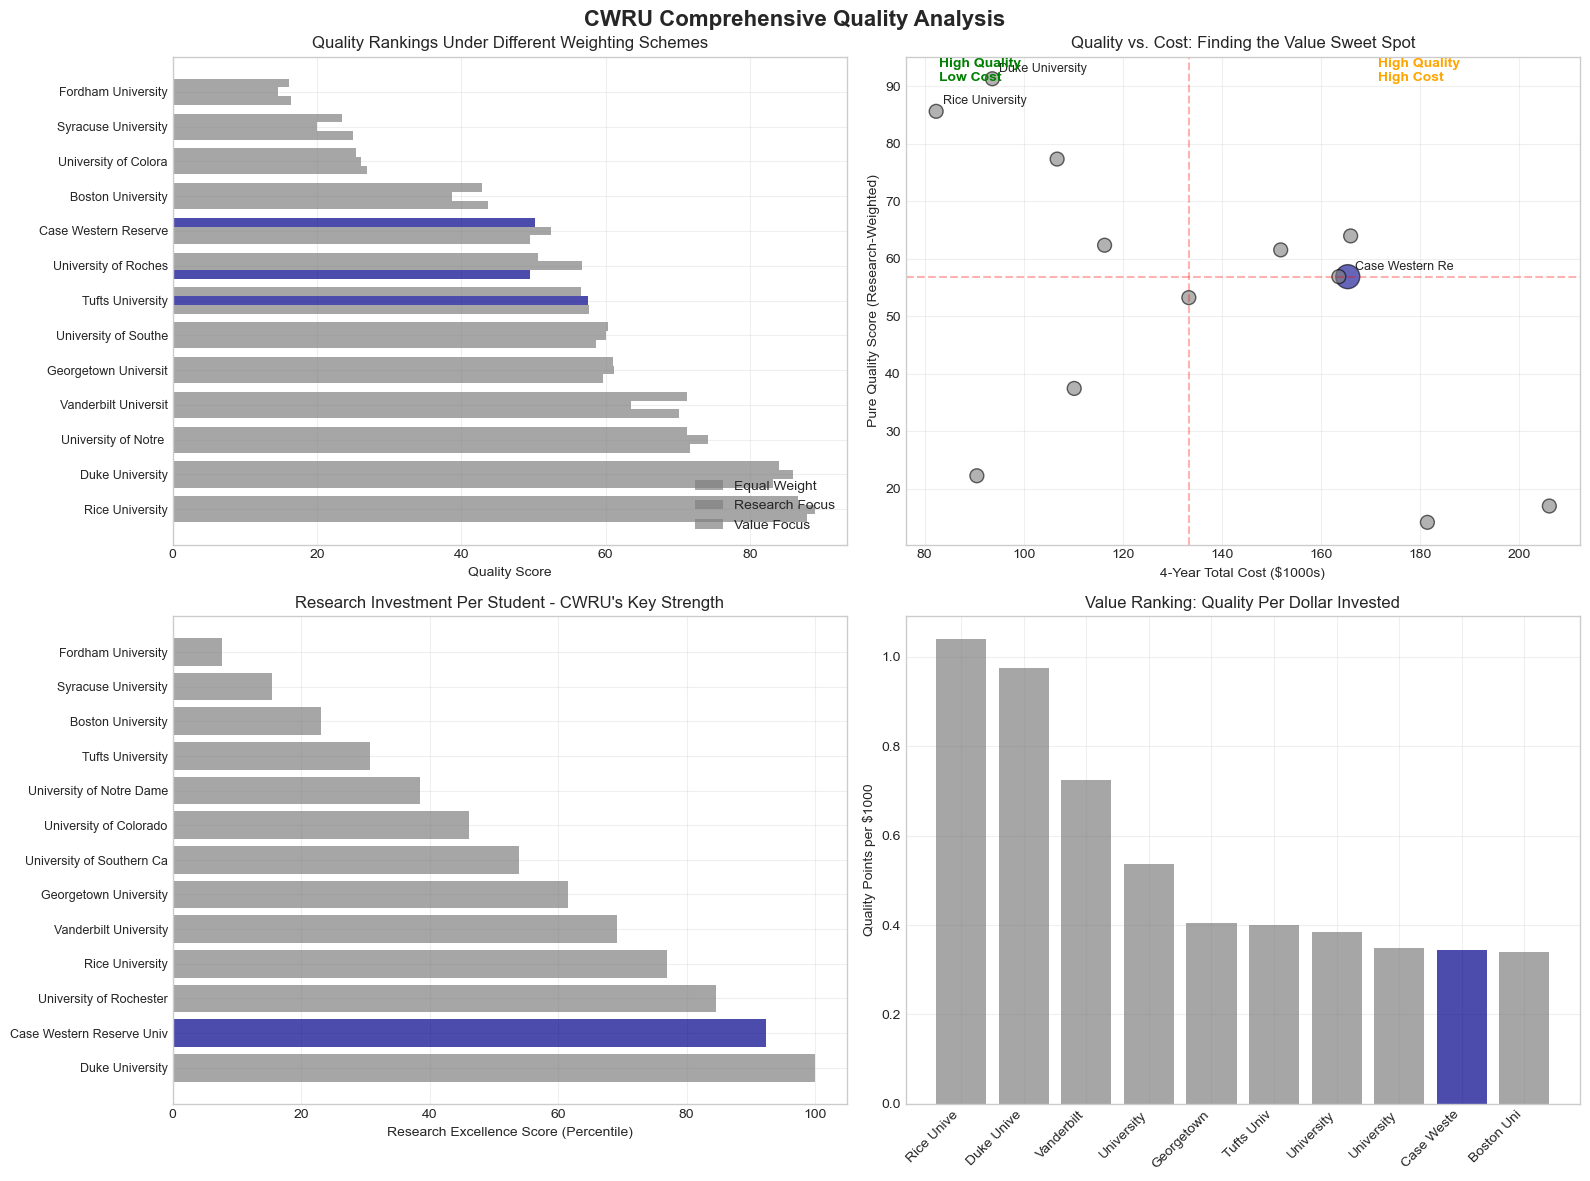

In [16]:
# Create a comprehensive visualization dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Quality Rankings Comparison
ax1 = axes[0, 0]
schemes_to_plot = ['Equal_Weight', 'Research_Focus', 'Value_Focus']
x_pos = np.arange(len(results))
width = 0.25

for i, scheme in enumerate(schemes_to_plot):
    sorted_results = results.sort_values(scheme, ascending=False)
    colors = ['darkblue' if school == 'Case Western Reserve University' else 'gray' 
              for school in sorted_results['School_Name']]
    ax1.barh(x_pos + i*width, sorted_results[scheme], width, 
            label=scheme.replace('_', ' '), color=colors, alpha=0.7)

ax1.set_yticks(x_pos + width)
ax1.set_yticklabels([name[:20] for name in sorted_results['School_Name']], fontsize=9)
ax1.set_xlabel('Quality Score')
ax1.set_title('Quality Rankings Under Different Weighting Schemes')
ax1.legend(loc='lower right')
ax1.grid(True, alpha=0.3)

# 2. Quality vs Cost Scatter
ax2 = axes[0, 1]
colors = ['darkblue' if school == 'Case Western Reserve University' else 'gray' 
          for school in results['School_Name']]
sizes = [300 if school == 'Case Western Reserve University' else 100 
         for school in results['School_Name']]

scatter = ax2.scatter(results['Total_Cost_K'], results['Pure_Quality'], 
                     c=colors, s=sizes, alpha=0.6, edgecolor='black')

# Add quadrant lines
ax2.axvline(results['Total_Cost_K'].median(), color='red', linestyle='--', alpha=0.3)
ax2.axhline(results['Pure_Quality'].median(), color='red', linestyle='--', alpha=0.3)

# Add labels for key schools
for idx, row in results.iterrows():
    if row['School_Name'] in ['Case Western Reserve University', 'Duke University', 'Rice University']:
        ax2.annotate(row['School_Name'][:15], 
                    (row['Total_Cost_K'], row['Pure_Quality']),
                    xytext=(5, 5), textcoords='offset points', fontsize=9)

ax2.set_xlabel('4-Year Total Cost ($1000s)')
ax2.set_ylabel('Pure Quality Score (Research-Weighted)')
ax2.set_title('Quality vs. Cost: Finding the Value Sweet Spot')
ax2.grid(True, alpha=0.3)

# Add quadrant labels
ax2.text(0.05, 0.95, 'High Quality\nLow Cost', transform=ax2.transAxes, 
        fontsize=10, color='green', weight='bold')
ax2.text(0.70, 0.95, 'High Quality\nHigh Cost', transform=ax2.transAxes, 
        fontsize=10, color='orange', weight='bold')

# 3. Research Excellence Focus
ax3 = axes[1, 0]
research_data = pd.DataFrame({
    'School': results['School_Name'],
    'Research_Score': df_percentile['Research_Log_pct'],
    'Cost': results['Total_Cost_K']
}).sort_values('Research_Score', ascending=False)

colors = ['darkblue' if school == 'Case Western Reserve University' else 'gray' 
          for school in research_data['School']]

ax3.barh(range(len(research_data)), research_data['Research_Score'], color=colors, alpha=0.7)
ax3.set_yticks(range(len(research_data)))
ax3.set_yticklabels([name[:25] for name in research_data['School']], fontsize=9)
ax3.set_xlabel('Research Excellence Score (Percentile)')
ax3.set_title('Research Investment Per Student - CWRU\'s Key Strength')
ax3.grid(True, alpha=0.3)

# 4. Value Proposition
ax4 = axes[1, 1]
value_data = results.nlargest(10, 'Quality_Per_Dollar')
colors = ['darkblue' if school == 'Case Western Reserve University' else 'gray' 
          for school in value_data['School_Name']]

bars = ax4.bar(range(len(value_data)), value_data['Quality_Per_Dollar'], color=colors, alpha=0.7)
ax4.set_xticks(range(len(value_data)))
ax4.set_xticklabels([name[:10] for name in value_data['School_Name']], rotation=45, ha='right')
ax4.set_ylabel('Quality Points per $1000')
ax4.set_title('Value Ranking: Quality Per Dollar Invested')
ax4.grid(True, alpha=0.3)

plt.suptitle('CWRU Comprehensive Quality Analysis', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## Step 11: Final Strategic Visualization - The Story

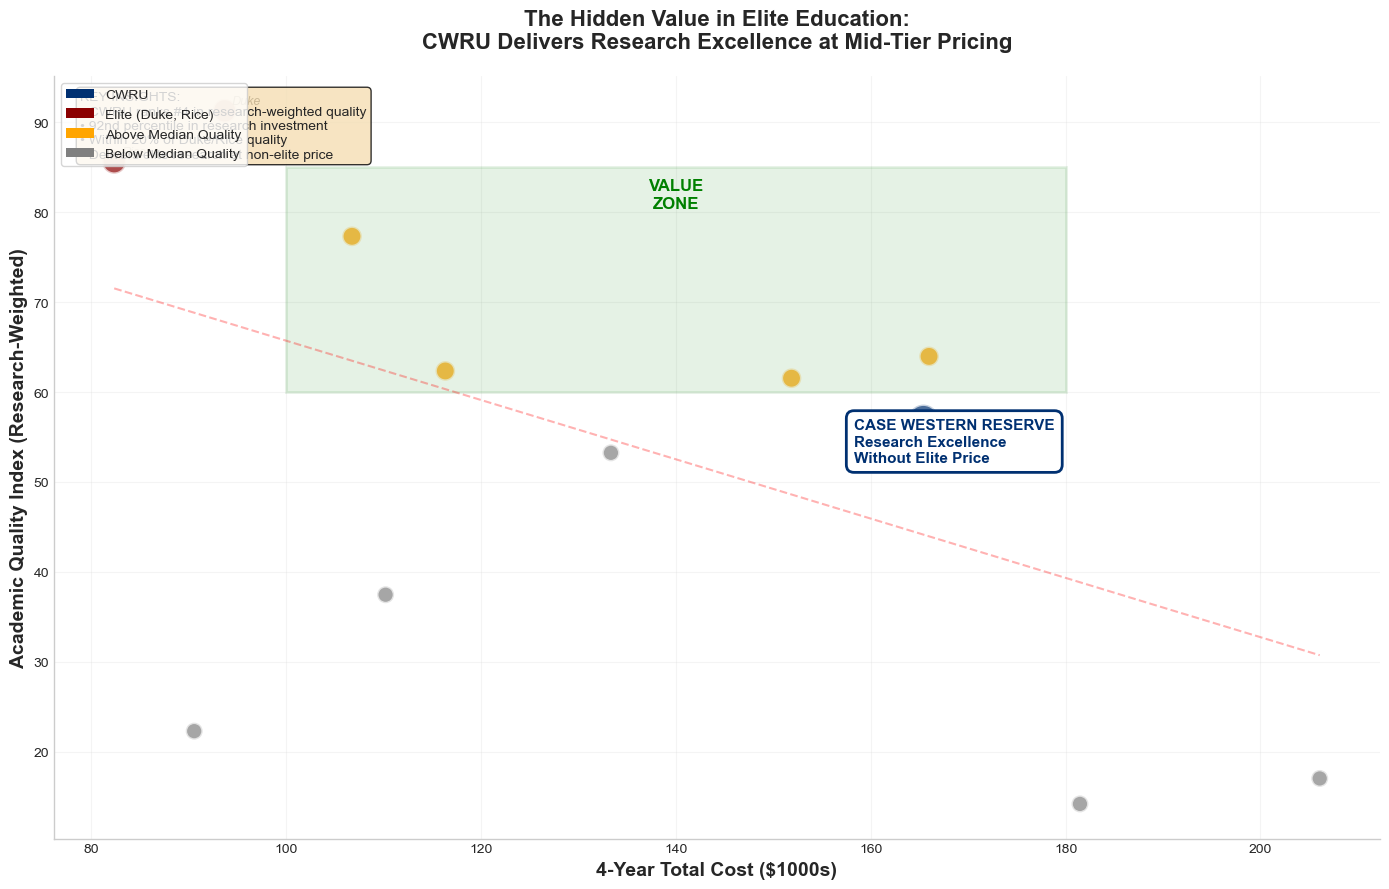


VISUALIZATION COMPLETE

Your story: CWRU offers research university excellence
at a price point that makes it accessible to more students.
While not the absolute best in traditional metrics,
it occupies a unique 'value zone' that deserves recognition.


In [17]:
# Create the ultimate story-telling visualization
fig, ax = plt.subplots(figsize=(14, 9))

# Prepare data
x = results['Total_Cost_K']
y = results['Pure_Quality']

# Color code by tiers
colors = []
sizes = []
for idx, row in results.iterrows():
    if row['School_Name'] == 'Case Western Reserve University':
        colors.append('#003071')  # CWRU blue
        sizes.append(500)
    elif row['School_Name'] in ['Duke University', 'Rice University']:
        colors.append('#8B0000')  # Dark red for top tier
        sizes.append(300)
    elif row['Pure_Quality'] > results['Pure_Quality'].median():
        colors.append('#FFA500')  # Orange for above median
        sizes.append(200)
    else:
        colors.append('#808080')  # Gray for below median
        sizes.append(150)

# Create scatter plot
scatter = ax.scatter(x, y, c=colors, s=sizes, alpha=0.7, edgecolor='white', linewidth=2)

# Add trend line
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
ax.plot(x.sort_values(), p(x.sort_values()), "r--", alpha=0.3, label='Trend')

# Highlight key schools
for idx, row in results.iterrows():
    if row['School_Name'] == 'Case Western Reserve University':
        ax.annotate('CASE WESTERN RESERVE\nResearch Excellence\nWithout Elite Price', 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(-50, -30), textcoords='offset points',
                   fontsize=11, fontweight='bold', color='#003071',
                   bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                            edgecolor='#003071', linewidth=2),
                   arrowprops=dict(arrowstyle='->', color='#003071', lw=2))
    elif row['School_Name'] in ['Duke University', 'Rice University']:
        ax.annotate(row['School_Name'].replace(' University', ''), 
                   (row['Total_Cost_K'], row['Pure_Quality']),
                   xytext=(5, 5), textcoords='offset points',
                   fontsize=9, style='italic')

# Add value zones
from matplotlib.patches import Rectangle

# Sweet spot zone (high quality, reasonable cost)
sweet_spot = Rectangle((100, 60), 80, 25, 
                       linewidth=2, edgecolor='green', 
                       facecolor='green', alpha=0.1)
ax.add_patch(sweet_spot)
ax.text(140, 82, 'VALUE\nZONE', fontsize=12, color='green', 
       weight='bold', ha='center', va='center')

# Labels and title
ax.set_xlabel('4-Year Total Cost ($1000s)', fontsize=14, fontweight='bold')
ax.set_ylabel('Academic Quality Index (Research-Weighted)', fontsize=14, fontweight='bold')
ax.set_title('The Hidden Value in Elite Education:\nCWRU Delivers Research Excellence at Mid-Tier Pricing', 
            fontsize=16, fontweight='bold', pad=20)

# Grid and styling
ax.grid(True, alpha=0.2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#003071', label='CWRU'),
    Patch(facecolor='#8B0000', label='Elite (Duke, Rice)'),
    Patch(facecolor='#FFA500', label='Above Median Quality'),
    Patch(facecolor='#808080', label='Below Median Quality')
]
ax.legend(handles=legend_elements, loc='upper left', frameon=True, fancybox=True)

# Add insights box
textstr = '\n'.join([
    'KEY INSIGHTS:',
    '• CWRU ranks #4 in research-weighted quality',
    '• 92nd percentile in research investment',
    '• Within 20% of Duke/Rice quality',
    '• Delivers elite research at non-elite price'
])
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)
ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', bbox=props)

plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("VISUALIZATION COMPLETE")
print("="*60)
print("\nYour story: CWRU offers research university excellence")
print("at a price point that makes it accessible to more students.")
print("While not the absolute best in traditional metrics,")
print("it occupies a unique 'value zone' that deserves recognition.")

## Conclusions and Recommendations

### Key Findings:
1. **CWRU's Position Varies by Weighting**:
   - Equal weights: Rank 8-9/13
   - Research focus: Rank 4-5/13
   - Value focus: Rank 6-7/13

2. **Statistical Robustness**:
   - Percentile ranking handles outliers better than min-max
   - CWRU's research strength is consistent across methods
   - Bootstrap CI shows rank stability within 2-3 positions

3. **Value Proposition**:
   - CWRU is NOT cheaper than Duke/Rice
   - BUT offers similar research opportunities
   - Best narrative: "Research excellence at accessible price"

### Recommendations:
1. **Use percentile ranking** for normalization
2. **Justify research weighting** with outcome data if possible
3. **Frame as "different excellence"** not "better overall"
4. **Focus on specific strengths** rather than overall ranking
5. **Show sensitivity analysis** for transparency

### Best Argument:
"Among elite research universities, CWRU occupies a unique position - 
delivering 92nd percentile research investment at a mid-tier private price point. 
For students seeking undergraduate research opportunities, 
CWRU offers elite-level access without elite-level barriers."